# Fundamentals of Machine Learning (CSCI-UA.473)

## Homework 2
### Due: October 26th, 2023 at 11:59PM

### Name: Gil Halevi
### Email: gh2354@nyu.edu


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

## Use the same dataset that was released with HW1
from google.colab import drive
drive.mount('/content/drive')

# Load the entire dataset from the CSV file
data = pd.read_csv('/content/drive/MyDrive/FML/HW1/FML2023_HW1_Dataset.csv')
# data = pd.read_csv('FML2023_HW1_Dataset.csv')
# Separate the features, target values, and feature names
X = data.drop('target', axis=1)
y = data['target'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Mounted at /content/drive


### Question 1: Maximum Likelihood Estimation (MLE) vs Maximum A Posteriori (MAP) (25 points)

In Homework 1, we performed linear and ridge regression. To summarize:

In Linear regression,

$$\beta = \arg\min_{\beta}\sum\left(y_i - \left(\beta_0 + \beta_1 x_{1i} +, \ldots, + \beta_px_{p i}\right)\right)^2$$


* $J(\beta)$ is the cost function.
* $\beta_0,\ldots,\beta_p$ are the coefficients for the features.
* $x_{1i}$ represents the values of the feature for the i-th observation.
* $y_i$ is the target value for the i-th observation.

For ridge regression

$$J(\beta) = \sum\left(y_i - \left(\beta_0 + \beta_1 x_{1i} +, \ldots, + \beta_px_{p i}\right)\right)^2 + \lambda \cdot \sum \beta_i^2$$

* $\lambda$ is the regularization hyper-parameter.

**Task 1.1 (5 points)** Linear regression embodies Maximum Likelihood Estimation (MLE). Show that a closed form expression is $$\beta = (\mathbf{A}^\top \mathbf{A})^{-1}\mathbf{A}^\top \mathbf{Y}$$ where $\mathbf{A} = [X_1,\ldots,X_n]$ and $\mathbf{Y} = [Y_1,\ldots,Y_n]$.

Answer:
the initial expression can be written as $||Y-A\beta||^2 = (Y-A\beta)^T(Y-A\beta) = Y^TY-Y^TA\beta - \beta^T A^T Y + \beta^T A^T A \beta$,

where $\beta = \beta_1...\beta_p$

The gradient of this expression with respect to $\beta$ is
$$-2A^TY + 2 A^T A \beta$$
Setting this to 0, we get

$$A^T A \beta = A^T Y$$
$$\beta = (A^T A)^{-1}A^T Y$$
**Task 1.2 (5 points)**: Ridge regression embodies Maximum A Posteriori (MAP), wherein the regularizer serves as the prior. Show that a closed form expression for the ridge estimator is $$\beta = (\mathbf{A}^\top \mathbf{A} + \lambda I)^{-1}\mathbf{A}^\top \mathbf{Y}$$ where $\mathbf{A} = [X_1,\ldots,X_n]$ and $\mathbf{Y} = [Y_1,\ldots,Y_n]$.

Similar to above, we have to minimize the expression
$Y^TY-Y^TA\beta - \beta^T A^T Y + \beta^T A^T A \beta -\lambda \beta$

taking the gradient and setting it to 0, we get
$$-2A^TY + 2 A^T A \beta - \lambda \beta = 0$$
$$(A^T A -\lambda I) \beta = A^T Y$$
$$\beta = (A^T A - \lambda I)^{-1}A^T Y$$

**Task 1.3 Implementation (10 points):** Fill in the code below to differentiate between MLE and MAP.

**Task 1.4 (5 points):**
* Do MLE and MAP yield distinct solutions as the sample size tends to infinity? Explain your answer.

* Will the impact of prior be greater with a small or large sample size, and what is the underlying rationale for this phenomenon?



In [3]:
def mle_linear_regression(X, y):
    X = np.concatenate((X,np.ones((X.shape[0],1))),axis=1)
    # Compute the MLE estimates using closed-form solution (HINT: Use np.linalg.inv)
    return np.linalg.inv(X.T @ X) @ X.T @ y

# Calculate MLE estimates without bias
theta_mle = mle_linear_regression(X_train.to_numpy(), y_train)

# Make predictions on the test set
X_test_with_ones = np.concatenate((X_test.to_numpy(), np.ones((X_test.shape[0],1))), axis=1)
y_preds = np.matmul(X_test_with_ones,theta_mle)
# Calculate Mean Squared Error (MSE)
mse_mle = np.mean((y_test - y_preds)**2)
print(f"MSE using MLE: {mse_mle}")

MSE using MLE: 2900.1936284934754


In [4]:
def map_linear_regression(X, y, lambda_reg):
    # Compute MAP estimates with L2 regularization
    X = np.concatenate((X,np.ones((X.shape[0],1))),axis=1)
    return np.linalg.inv((X.T @ X) + (lambda_reg*np.identity(X.shape[1]))) @ X.T @ y

# Set the regularization parameter (lambda)
lambda_reg = 0.1
theta_map = map_linear_regression(X_train.to_numpy(), y_train, lambda_reg)

# Make predictions on the test set
X_test_with_ones = np.concatenate((X_test.to_numpy(), np.ones((X_test.shape[0],1))), axis=1)
y_preds = np.matmul(X_test_with_ones,theta_map)

# Calculate Mean Squared Error (MSE)
mse_map = np.mean((y_test - y_preds)**2)
print(f"MSE using MAP: {mse_map}")

MSE using MAP: 2856.810366181945


MLE and MAP yield the same solution as the sample size tends to infinity because the prediction loss will eclipse the regularization loss, since the prediction loss increases linearly with sample size while the regularization stays constant. In MAP terms, this means that the prior becomes less and less important as you see more data, and as you tend toward infinity it becomes irrelevant.

The impact of the prior is greater with smaller sample size. As said above, when you have seen less data, you rely more on priors. This is because there are many different true parameters that could be consistent with a small sample, so you rely on your prior to determine which of these consistent true parameters is most likely.

### Question 2: Classification with imbalanced dataset (20 points)

We are creating an imbalanced version of the target variable for the Z dataset. An imbalanced dataset means that one class is much more frequent than the other class. In our case, we will consider the two classes as follows:

- Class 0: Z progression values that are below the 75th percentile of the original target variable.
- Class 1: Z progression values that are above the 75th percentile of the original target variable.

By doing this, we are creating an imbalance where Class 0 will be more prevalent than Class 1, mimicking a common scenario in real-world imbalanced datasets.

In [5]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# Shuffle the data
X, y = shuffle(X, y, random_state=42)

# Create an imbalanced target variable
y_imbalanced = np.where(y > np.percentile(y, 75), 1, 0)

X_train, X_test, y_train, y_test = train_test_split(X, y_imbalanced, test_size=0.2, random_state=42)


**Task 2.1 (3 points):**
- Create a SVM classifier with a linear kernel, then calculate accuracy, precision, recall, and F1 score using available library functions.

In [11]:
from sklearn import svm
import sklearn
### Add code here
svm_model = svm.LinearSVC()
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)
def model_scores(y_test, y_pred):
  accuracy = sklearn.metrics.accuracy_score(y_test,y_pred)
  precision = sklearn.metrics.precision_score(y_test,y_pred, zero_division=0)
  recall = sklearn.metrics.recall_score(y_test,y_pred,zero_division=0)
  f1 = sklearn.metrics.f1_score(y_test,y_pred)
  return {"accuracy":accuracy,"precision":precision, "recall":recall, "f1":f1}
print(model_scores(y_test,y_pred))

{'accuracy': 0.8876404494382022, 'precision': 0.7, 'recall': 0.5, 'f1': 0.5833333333333334}



**Task 2.2 (5 points):** What causes the metrics to exhibit lower values for the imbalanced dataset compared to those in homework 1?

Since the model is trained on many more negative samples than positive one, it learns to optimize by classifying everything as negataive, as this results in pretty good performance. When the dataset is more balanced, classifying everything as positive or everything as negative results in much worse performance, so the model must instead learn

**Random oversampling** is one of the many techniques used to address the class imbalance problem. It involves increasing the number of instances in the minority class by randomly duplicating existing instances. This helps to balance the class distribution and can lead to improved performance for certain models.

**Task 2.3 (2 points):** Calculate and display the following statistics for the target variable (y) before applying random oversampling:
  - Mean
  - Standard Deviation
  - Minimum
  - Maximum

**Task 2.4 (5 points):** Perform random oversampling on the training set. After oversampling, calculate and display the same statistics for the oversampled target variable.

In [12]:
import numpy as np
print(y_imbalanced.shape[0])
def print_summary_stats(data):
  mean = np.mean(data)
  std = np.std(data)
  min = np.min(data)
  max = np.max(data)
  print("mean:"+str(mean))
  print("stdev:"+str(std))
  print("min:"+str(min))
  print("max:"+str(max))
print_summary_stats(y_imbalanced)

442
mean:0.251131221719457
stdev:0.4336638458496972
min:0
max:1


In [ ]:
# Apply Random Oversampling
positive_indices = np.where(y_imbalanced == 1)[0]
oversamples = np.random.choice(positive_indices,220)
y_balanced = np.concatenate((y_imbalanced,y_imbalanced[oversamples]))
X_balanced = pd.concat((X,X.iloc[oversamples]))


X_balanced_train, X_balanced_test, y_balanced_train, y_balanced_test = train_test_split(X, y_imbalanced, test_size=0.2, random_state=42)
print_summary_stats(y_balanced)

**Task 2.5 (5 points):**
- Create another instance of SVM classifier with linear kernel, fit it on the oversampled data and calculate all the prior metrics for the oversampled model.
- Show the metrics with different regularization parameters {0.1, 1, 10, 100} on the linear kernel.
- Show the metrics with polynomial degrees {-1, 0, 3, 4} and observe how the model's complexity changes.
- Introduce different values for the regularization parameter in the RBF kernel and show how it balances the trade-off between maximizing the margin and minimizing classification error.

In [13]:
### Add code here

def test_svm(model,X_test, y_test):
  y_pred = svm_model.predict(X_test)

from sklearn import svm
linear_models=dict()
for reg in [0.1,1,10,100]:
  linear_models[reg]=svm.LinearSVC(C=reg)
  linear_models[reg].fit(X_balanced_train,y_balanced_train)
  y_pred = linear_models[reg].predict(X_balanced_test)
  print("linear model with reg {} scores: {}".format(reg,model_scores(y_pred, y_balanced_test)))
poly_models=dict()
print()
for deg in [1,0,3,4]:
  poly_models[reg]=svm.SVC(kernel='poly',degree=deg)
  poly_models[reg].fit(X_balanced_train,y_balanced_train)
  y_pred = poly_models[reg].predict(X_balanced_test)
  print("poly model with degree {} scores: {}".format(deg,model_scores(y_pred, y_balanced_test)))
rbf_models=dict()
print()
for reg in [0.1,1,10,100]:
  rbf_models[reg]=svm.SVC(kernel='rbf',C=reg)
  rbf_models[reg].fit(X_balanced_train,y_balanced_train)
  y_pred = rbf_models[reg].predict(X_balanced_test)
  print("rbf model with reg {} scores: {}".format(reg,model_scores(y_pred, y_balanced_test)))


linear model with reg 0.1 scores: {'accuracy': 0.8426966292134831, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}
linear model with reg 1 scores: {'accuracy': 0.8876404494382022, 'precision': 0.5, 'recall': 0.7, 'f1': 0.5833333333333334}
linear model with reg 10 scores: {'accuracy': 0.8876404494382022, 'precision': 0.5714285714285714, 'recall': 0.6666666666666666, 'f1': 0.6153846153846153}
linear model with reg 100 scores: {'accuracy': 0.8876404494382022, 'precision': 0.5714285714285714, 'recall': 0.6666666666666666, 'f1': 0.6153846153846153}

poly model with degree 1 scores: {'accuracy': 0.8876404494382022, 'precision': 0.5714285714285714, 'recall': 0.6666666666666666, 'f1': 0.6153846153846153}
poly model with degree 0 scores: {'accuracy': 0.8426966292134831, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}
poly model with degree 3 scores: {'accuracy': 0.8651685393258427, 'precision': 0.42857142857142855, 'recall': 0.6, 'f1': 0.5}
poly model with degree 4 scores: {'accuracy': 0.83146067415730

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


### Question 3: Naive Bayes Model (10 points)

Implement the Naieve Bayes classifer on the Z dataset.

We will assume that each continuous feature $X_i$ of $X$ follow a Gaussian distribution within each class $Y$.

- For each class $c$, calculate the mean $(\mu_c)$ and standard deviation $(\sigma_c)$ for each feature. These parameters represent the central tendency and spread of the feature values within each class. They can be computed as:

   \begin{align*}
   \mu_c^j &= \frac{1}{N_c} \sum_{i=1}^{N_c} X_i^j \quad \text{(mean of feature \(j\) in class \(c\))} \\
   \sigma_c^j &= \sqrt{\frac{1}{N_c} \sum_{i=1}^{N_c} (X_i^j - \mu_c^j)^2} + \epsilon \quad \text{(standard deviation of feature \(j\) in class \(c\))}
   \end{align*}
     
   where $N_c$ is the number of data points in class $c$, and $\varepsilon=1e^{-6}$ is a small constant added for numerical stability.

- To make a prediction for a new data point $x$, calculate the probability of $x$ belonging to each class $c$ using the Gaussian probability density function:

   \begin{align*}
   P(X^j = x^j | Y = c) = \frac{1}{\sqrt{2\pi}\sigma_c^j} e^{-\frac{1}{2}\left(\frac{x^j - \mu_c^j}{\sigma_c^j}\right)^2}
   \end{align*}

- Calculate the class probability $P(Y = c | X = x)$ as the product of the probabilities of each feature:

    \begin{align*}
     P(Y = c | X = x) = P(Y = c) \prod_{j=1}^{D} P(X^j = x^j | Y = c)
    \end{align*}

   where $D$ is the number of features.

- Assign the class label to the class with the highest probability:

    \begin{align*}
     \hat{Y} = \arg\max_{c} P(Y = c | X = x)
     \end{align*}

**Hint:** In the code for Gaussian Naive Bayes, we take logarithms in certain calculations. This is a common technique used to avoid numerical underflow, especially when working with small probabilities.

In [14]:
import numpy as np


class GaussianNaiveBayes:

    def fit(self, X, y):
        self.classes = np.unique(y)
        self.parameters = dict()
        if isinstance(X, pd.DataFrame):
          X = X.to_numpy()
        for c in self.classes:
          class_Xs = X[np.where(y==c)[0]]
          self.parameters[c] = {"prior":(class_Xs.shape[0])/X.shape[0],"mean":np.mean(class_Xs,axis=0),"std":np.std(class_Xs,axis=0)+1e-6 }
          # print(self.parameters[c])

    def _calculate_log_likelihood(self, x, mean, std):
        ### Compute the log likelihood of the given data point with the means and stds
        log_prob = 0
        for i in range(x.shape[0]):
          log_prob += (1/2*(((x[i]-mean[i])/std[i])**2)) * (np.log(std[i] * np.sqrt(2*np.pi)))
        return log_prob

    def _calculate_class_probability(self, x, c):
        c=c.item()
        p_y_c = self.parameters[c]['prior']
        sum_log_prob = 0
        for i in range(x.shape[0]):
          sum_log_prob+=self._calculate_log_likelihood(x,self.parameters[c]['mean'], self.parameters[c]['std'])
        return p_y_c * np.exp(sum_log_prob)

    def predict(self, X):
      if isinstance(X, pd.DataFrame):
        X = X.to_numpy()
      predicted_classes=[]
      for i in range(X.shape[0]):
        class_ps = np.asarray([self._calculate_class_probability(X[i],c) for c in np.nditer(self.classes)])
        predicted_class = self.classes[np.argmax(class_ps)]
        predicted_classes.append(predicted_class)
      return np.asarray(predicted_classes)

    def score(self, X, y):
        if isinstance(X, pd.DataFrame):
          X = X.to_numpy()
        y_pred = self.predict(X)
        accuracy = np.mean(y_pred == y)
        return accuracy

# Initialize and train the Gaussian Naive Bayes classifier
gnb = GaussianNaiveBayes()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)
accuracy = gnb.score(X_test, y_test)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8202247191011236


### Question 4: ROC curve and AUROC (15 points)

**Task 4.1 (3 points):** Imagine you are a public health researcher investigating the performance of a new diagnostic test for disease Z, which is a potentially life-threatening condition. The test is designed to identify individuals who have the disease. You have collected data from a group of 500 patients who were tested for disease Z, and the results are as follows:

Out of 150 patients who actually have disease Z, the test correctly identified 120 of them as positive.
However, the test also falsely identified 50 patients who do not have disease Z as positive.

* **Precision:** Define precision in the context of this diagnostic test for disease Z. Calculate the precision of the test based on the provided data.
* **Recall:** Explain what recall means in this scenario. Calculate the recall of the test based on the provided data.
* **F1-score:** Define the F1-score and explain why it is important, especially in the context of diagnosing a serious disease like Z. Calculate the F1-score of the test based on the provided data.
* **Specificity:** What is specificity, and why is it relevant when evaluating a diagnostic test like this one? Calculate the specificity of the test based on the provided data.
* **Balanced Accuracy:** Describe what balanced accuracy is and why it might be a useful metric in this situation. Calculate the balanced accuracy of the test based on the provided data.

Precision is the proportion of people diagnosed with disease Z that actually have disease Z. The precision in this case is 120/(120+50)=0.71

Recall is the proportion of people with disease Z who were diagnosed with disease Z. The recall in this case is 120/150 = 0.8

F1 score is a combined metric of recall and precision, the "harmonic mean" of the two: 2/(1/precision + 1/recall). This is important because for a serious disease, both false negatives and false positives are quite harmful and you want a model that has low rates of both. In this case the F1 score is 2/((1/0.8)+(1/0.71))=0.75

Specificity is the proportion of people who do not have disease Z that are classified as not having disease Z. it is useful because you don't want to have many false positives, since treatment can be expensive and risky. In this case it is 300/350 = 0.86


Balanced accuracy is purely the average between the specificity and recall (sensitivity). It might be useful for the same reason as f1, when you want a combined metric to minimize both false positives and false negatives. Unlike F1 score, balanced accuracy also takes into account true positives. In this case it is (0.86+0.8)/2 = 0.83


**Task 4.2 (6 Points)** Plot the ROC curve

An ROC curve plots TPR (y-axis) vs. FPR (x-axis) at all classification thresholds. Lowering the classification threshold classifies more items as positive, thus increasing both False Positives and True Positives.

See this for more details (https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)

Plot the ROC curve for Disease Z HW1 dataset with SVM classifier. **Note that you are not allowed to use any library function to compute the ROC. You have to do it from scratch.**

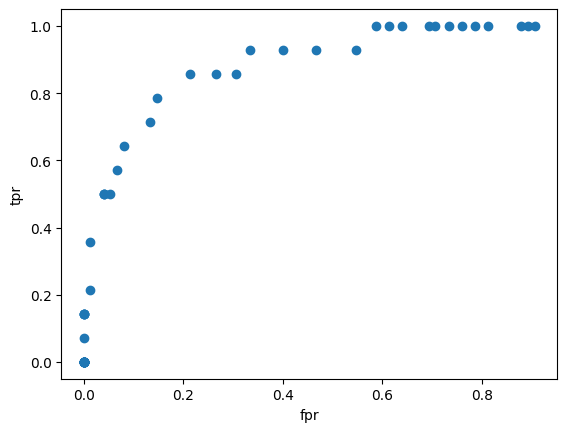

In [18]:
## Your code to compute and plot ROC goes here
import matplotlib.pyplot as plt

from sklearn import svm
import sklearn


fprs=[]
tprs=[]
l_model=svm.LinearSVC()
l_model.fit(X_balanced_train,y_balanced_train)
y_pred_raw = l_model.decision_function(X_balanced_test)
for threshold in np.arange(1.25,-1.3,-0.05):
  y_pred = y_pred_raw >= threshold
  tp = np.count_nonzero(np.logical_and(y_balanced_test == 1, y_pred == 1))
  fp = np.count_nonzero(np.logical_and(y_balanced_test == 0, y_pred == 1))
  tn = np.count_nonzero(np.logical_and(y_balanced_test == 0, y_pred == 0))
  fn = np.count_nonzero(np.logical_and(y_balanced_test == 1, y_pred == 0))
  tprs.append(tp / (tp + fn))
  fprs.append(fp / (tn + fp))

plt.scatter(fprs,tprs)
plt.ylabel("tpr")
plt.xlabel("fpr")
plt.show()

**Task 4.3 (6 Points):** Compute the AUC of ROC

AUC stands for "Area under the ROC Curve." That is, AUC measures the entire two-dimensional area underneath the entire ROC curve (think integral calculus) from (0,0) to (1,1). AUC provides an aggregate measure of performance across all possible classification thresholds. One way of interpreting AUC is as the probability that the model ranks a random positive example more highly than a random negative example.

Compute the AUC of your SVM model. **Note that you are not allowed to use any library function to compute the AUC. You have to do it from scratch.**

In [19]:
## Your code to compute the AUC goes here
auc = 0
for i in range(len(fprs)-1):
  auc += (tprs[i]+tprs[i+1])/2 * (fprs[i+1] - fprs[i])
print(auc)

0.797142857142857
